##  [quiz] 2021년 11월 1일~ 2022년 1월 27일 코로나 확진자를 학습하고 이후 확진자수 예측하라

In [8]:
# 3일 동안의 확진자 수 추이를 보고 다음 날의 확진자 수를 예측
# 따라서 인공지능은 3일 동안의 확진자 수를 보고 다음 날의 확진자 수가 어떻게 되었는지 학습
# 만약 100일 동안의 확진자 수가 있다면 가장 먼저 1, 2, 3일차의 확진자 수가 어떻게 변하였는지 살펴보고 4일차의 확진자 수를 학습한다
# 그리고 2, 3, 4일차의 확진자 수가 어떻게 변하였는지 살펴보고 5일차의 확진자 수를 학습한다
# 이러한 방식으로 계속 학습하여 97, 98, 99일차의 확진자 수로 100일차의 확진자 수를 학습한다
# 연속된 데이터의 형태에서 그 패턴을 찾아내는 순환 신경망(RNN) 방식으로, RNN의 기본적인 형태를 설계하고 학습시켜 본다

# RNN-코로나19 확진자수 예측

#### 필요한 라이브러리 임포트

In [9]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [10]:
from tensorflow.python.client import device_lib
import tensorflow as tf
with tf.device('/device:GPU:0'): 
    device_lib.list_local_devices()

In [11]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

#### 코로나 데이터 가져오기

In [12]:
import tensorflow as tf
with tf.device('/device:GPU:0'): 
    df = pd.read_csv('data/covid_2021101_20220127.csv')
    df

#### 데이터 정규화 및 분류하기

In [13]:
df.shape

(88, 5)

#### 데이터 형태 변경하기

In [14]:
df1 = df['new_patient'][1:]
df1

1      1588.0
2      2667.0
3      2482.0
4      2343.0
5      2246.0
       ...   
83     7626.0
84     7511.0
85     8570.0
86    13010.0
87    14515.0
Name: new_patient, Length: 87, dtype: float64

In [15]:
df2 = pd.DataFrame(columns=['day1', 'day2', 'day3', 'day4'])

In [16]:
69 / 4

17.25

In [17]:
k = 0
for i in range(18):
    temp_row = []
    for j in range(1, 5):
        temp_row.append(df1[j+k])
    df2.loc[f'{i}'] = temp_row
    k += 4
    if k > 65:
        break

In [18]:
df2

,day1,day2,day3,day4
0,1588.0,2667.0,2482.0,2343.0
1,2246.0,2225.0,1754.0,1717.0
2,2425.0,2518.0,2368.0,2324.0
3,2418.0,2004.0,2122.0,3189.0
4,3292.0,3033.0,3205.0,3120.0
5,2827.0,2697.0,4113.0,3937.0
6,3896.0,4067.0,3925.0,3307.0
7,3031.0,5122.0,5263.0,4944.0
8,5352.0,5125.0,4324.0,4953.0
9,7173.0,7375.0,6748.0,6977.0


In [19]:
X = df2[['day1', 'day2', 'day3']]
y = df2['day4']

In [20]:
#### shuffle=False임을 유의할 것
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

### 인공지능 모델 만들기

In [21]:
X_train.shape

(13, 3)

In [22]:
X_train

,day1,day2,day3
0,1588.0,2667.0,2482.0
1,2246.0,2225.0,1754.0
2,2425.0,2518.0,2368.0
3,2418.0,2004.0,2122.0
4,3292.0,3033.0,3205.0
5,2827.0,2697.0,4113.0
6,3896.0,4067.0,3925.0
7,3031.0,5122.0,5263.0
8,5352.0,5125.0,4324.0
9,7173.0,7375.0,6748.0


In [23]:
import numpy as np
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

In [24]:
X_train.shape

(13, 3, 1)

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

model = Sequential([
    SimpleRNN(units=256, return_sequences=False, input_shape=(3, 1)),
    Dense(1)
])
model.compile(loss='mse', metrics='mae', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 256)               66048     
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 66,305
Trainable params: 66,305
Non-trainable params: 0
_________________________________________________________________


In [26]:
# 학습
hist = model.fit(X_train, y_train, epochs=100, verbose=2)

Epoch 1/100
1/1 - 1s - loss: 23533084.0000 - mae: 4445.2690 - 895ms/epoch - 895ms/step
Epoch 2/100
1/1 - 0s - loss: 23528286.0000 - mae: 4444.7402 - 4ms/epoch - 4ms/step
Epoch 3/100
1/1 - 0s - loss: 23525924.0000 - mae: 4444.4741 - 3ms/epoch - 3ms/step
Epoch 4/100
1/1 - 0s - loss: 23523648.0000 - mae: 4444.2178 - 4ms/epoch - 4ms/step
Epoch 5/100
1/1 - 0s - loss: 23521364.0000 - mae: 4443.9609 - 3ms/epoch - 3ms/step
Epoch 6/100
1/1 - 0s - loss: 23519084.0000 - mae: 4443.7046 - 4ms/epoch - 4ms/step
Epoch 7/100
1/1 - 0s - loss: 23516800.0000 - mae: 4443.4473 - 3ms/epoch - 3ms/step
Epoch 8/100
1/1 - 0s - loss: 23514520.0000 - mae: 4443.1909 - 6ms/epoch - 6ms/step
Epoch 9/100
1/1 - 0s - loss: 23512238.0000 - mae: 4442.9341 - 4ms/epoch - 4ms/step
Epoch 10/100
1/1 - 0s - loss: 23509956.0000 - mae: 4442.6772 - 7ms/epoch - 7ms/step
Epoch 11/100
1/1 - 0s - loss: 23507672.0000 - mae: 4442.4199 - 2ms/epoch - 2ms/step
Epoch 12/100
1/1 - 0s - loss: 23505390.0000 - mae: 4442.1636 - 5ms/epoch - 5ms/st

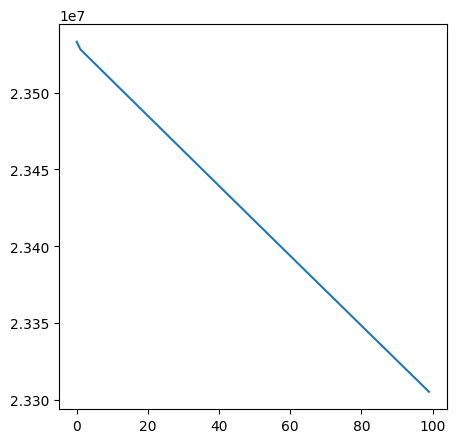

In [27]:
import pandas as pd
df = pd.DataFrame(hist.history)

import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
plt.plot(df.loss, label='train_loss')

In [28]:
model.predict(X_test)

1/1 [==============================] - 0s 212ms/step


array([[27.376348],
       [27.376348],
       [27.376348],
       [27.376348]], dtype=float32)

In [29]:
X_test.shape

(4, 3, 1)

#### 모델 학습

#### 결과 시각화

- - -

# 답안 풀이

In [30]:
df = pd.read_csv('data/covid_2021101_20220127.csv', usecols=[3], engine='python')
data = df.values
data = data.astype('float32')
data

array([[366382.],
       [367970.],
       [370637.],
       [373119.],
       [375462.],
       [377708.],
       [379933.],
       [381687.],
       [383404.],
       [385829.],
       [388347.],
       [390715.],
       [393039.],
       [395457.],
       [397461.],
       [399583.],
       [402772.],
       [406064.],
       [409097.],
       [412302.],
       [415422.],
       [418249.],
       [420946.],
       [425059.],
       [428996.],
       [432892.],
       [436959.],
       [440884.],
       [444191.],
       [447222.],
       [452344.],
       [457607.],
       [462551.],
       [467903.],
       [473028.],
       [477352.],
       [482305.],
       [489478.],
       [496853.],
       [503601.],
       [510578.],
       [517259.],
       [523075.],
       [528642.],
       [536491.],
       [544110.],
       [551544.],
       [558854.],
       [565087.],
       [570403.],
       [575595.],
       [583047.],
       [589961.],
       [596194.],
       [602034.],
       [60

### 데이터 정규화 및 분류하기


In [31]:
scaler = MinMaxScaler()
corona = scaler.fit_transform(data)
corona

array([[0.        ],
       [0.0038628 ],
       [0.01035023],
       [0.01638758],
       [0.02208692],
       [0.02755022],
       [0.0329625 ],
       [0.03722906],
       [0.04140562],
       [0.04730433],
       [0.05342931],
       [0.05918944],
       [0.06484252],
       [0.07072425],
       [0.0755989 ],
       [0.0807606 ],
       [0.08851779],
       [0.09652549],
       [0.10390317],
       [0.11169922],
       [0.11928856],
       [0.12616515],
       [0.1327256 ],
       [0.14273036],
       [0.15230703],
       [0.16178393],
       [0.17167675],
       [0.18122423],
       [0.18926847],
       [0.1966412 ],
       [0.20910037],
       [0.22190249],
       [0.23392868],
       [0.24694729],
       [0.25941372],
       [0.26993167],
       [0.2819798 ],
       [0.29942787],
       [0.31736743],
       [0.33378172],
       [0.35075307],
       [0.3670045 ],
       [0.3811518 ],
       [0.39469337],
       [0.41378582],
       [0.4323188 ],
       [0.4504019 ],
       [0.468

In [32]:
train, test = train_test_split(corona, test_size=0.2, shuffle=False) # 시퀀셜 데이터라 셔플 절대 하면 안됨
train.shape, test.shape

((70, 1), (18, 1))

### 데이터 형태 변경하기

In [33]:
def create_dataset(dataset, look_back):
    X_data = []
    y_data = []
    for i in range(len(dataset) - look_back):
        data = dataset[i:(i+look_back), 0]
        X_data.append(data)
        y_data.append(dataset[i + look_back, 0])
    return np.array(X_data), np.array(y_data)

In [34]:
look_back = 3 
X_train, y_train = create_dataset(train, look_back)
X_train, y_train

(array([[0.        , 0.0038628 , 0.01035023],
        [0.0038628 , 0.01035023, 0.01638758],
        [0.01035023, 0.01638758, 0.02208692],
        [0.01638758, 0.02208692, 0.02755022],
        [0.02208692, 0.02755022, 0.0329625 ],
        [0.02755022, 0.0329625 , 0.03722906],
        [0.0329625 , 0.03722906, 0.04140562],
        [0.03722906, 0.04140562, 0.04730433],
        [0.04140562, 0.04730433, 0.05342931],
        [0.04730433, 0.05342931, 0.05918944],
        [0.05342931, 0.05918944, 0.06484252],
        [0.05918944, 0.06484252, 0.07072425],
        [0.06484252, 0.07072425, 0.0755989 ],
        [0.07072425, 0.0755989 , 0.0807606 ],
        [0.0755989 , 0.0807606 , 0.08851779],
        [0.0807606 , 0.08851779, 0.09652549],
        [0.08851779, 0.09652549, 0.10390317],
        [0.09652549, 0.10390317, 0.11169922],
        [0.10390317, 0.11169922, 0.11928856],
        [0.11169922, 0.11928856, 0.12616515],
        [0.11928856, 0.12616515, 0.1327256 ],
        [0.12616515, 0.1327256 , 0

In [35]:
X_train.shape, y_train.shape

((67, 3), (67,))

In [36]:
X_test, y_test = create_dataset(test, look_back)
X_test.shape, y_test.shape

((15, 3), (15,))

In [37]:
# 인공 지능 모델의 입력 형태로 데이터 구조를 변환
X_train = X_train[:, np.newaxis]
X_test = X_test[:, np.newaxis]

In [38]:
X_train.shape, X_test.shape

((67, 1, 3), (15, 1, 3))

In [39]:
X_train[0]

array([[0.        , 0.0038628 , 0.01035023]], dtype=float32)

### 인공지능 모델 만들기

In [40]:
model = Sequential()
model.add(SimpleRNN(3, input_shape=(1, 3)))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', metrics='mae', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 3)                 21        
                                                                 
 dense_1 (Dense)             (None, 1)                 4         
                                                                 
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


### 모델 학습

In [41]:
hist = model.fit(X_train, y_train, epochs=100, batch_size=3, verbose=2)

Epoch 1/100
23/23 - 1s - loss: 0.0589 - mae: 0.1845 - 1s/epoch - 47ms/step
Epoch 2/100
23/23 - 0s - loss: 0.0274 - mae: 0.1246 - 45ms/epoch - 2ms/step
Epoch 3/100
23/23 - 0s - loss: 0.0147 - mae: 0.0980 - 41ms/epoch - 2ms/step
Epoch 4/100
23/23 - 0s - loss: 0.0099 - mae: 0.0873 - 42ms/epoch - 2ms/step
Epoch 5/100
23/23 - 0s - loss: 0.0079 - mae: 0.0802 - 38ms/epoch - 2ms/step
Epoch 6/100
23/23 - 0s - loss: 0.0064 - mae: 0.0725 - 46ms/epoch - 2ms/step
Epoch 7/100
23/23 - 0s - loss: 0.0052 - mae: 0.0658 - 55ms/epoch - 2ms/step
Epoch 8/100
23/23 - 0s - loss: 0.0041 - mae: 0.0582 - 75ms/epoch - 3ms/step
Epoch 9/100
23/23 - 0s - loss: 0.0032 - mae: 0.0511 - 69ms/epoch - 3ms/step
Epoch 10/100
23/23 - 0s - loss: 0.0025 - mae: 0.0448 - 31ms/epoch - 1ms/step
Epoch 11/100
23/23 - 0s - loss: 0.0019 - mae: 0.0398 - 25ms/epoch - 1ms/step
Epoch 12/100
23/23 - 0s - loss: 0.0014 - mae: 0.0338 - 21ms/epoch - 900us/step
Epoch 13/100
23/23 - 0s - loss: 0.0011 - mae: 0.0287 - 25ms/epoch - 1ms/step
Epoch 1

### 결과 시각화

In [42]:
import pandas as pd

df = pd.DataFrame(hist.history)

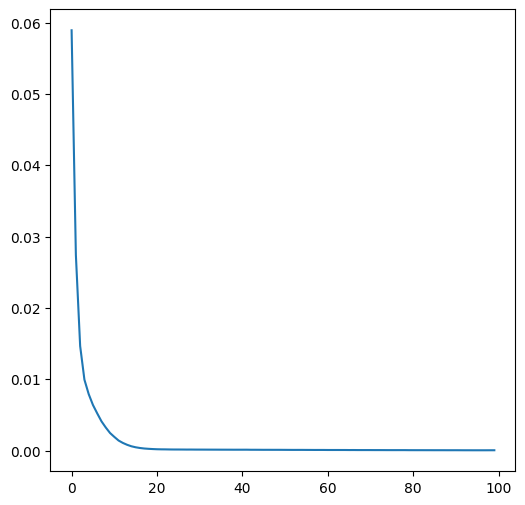

In [43]:
plt.figure(figsize=(6, 6))
plt.plot(df.index, df.loss)

In [48]:
scaler.inverse_transform(model.predict(X_test)), y_test

1/1 [==============================] - 0s 15ms/step


(array([[667704.1 ],
        [670116.94],
        [673118.06],
        [676031.56],
        [679066.06],
        [681961.94],
        [684661.75],
        [687226.06],
        [690141.25],
        [693937.06],
        [698049.06],
        [702187.94],
        [706447.6 ],
        [710844.6 ],
        [715165.8 ]], dtype=float32),
 array([0.7604791 , 0.77151763, 0.78226686, 0.7924564 , 0.80183125,
        0.8117119 , 0.8258276 , 0.8418819 , 0.85834   , 0.87537944,
        0.8939295 , 0.91219985, 0.9330462 , 0.9646927 , 1.        ],
       dtype=float32))